<a href="https://colab.research.google.com/github/j3nguyen/user_item_embeddings/blob/master/NextAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# spacy for lemmatization
# import spacy

# NLTK for stopwords and stemming
# from nltk.stem.porter import * 
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import keras

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Average, Dropout, Embedding, Activation, TimeDistributed, Concatenate, Flatten, Lambda
from keras.optimizers import Adam

In [0]:
df = pd.read_csv("events.csv")

In [0]:
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [0]:
# reformat the data set
visitor_ids = df.visitorid.unique()

In [0]:
df.shape

(2756101, 5)

In [0]:
df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [0]:
action_to_idx = {"view": 0, "addtocart": 1, "transaction": 2}

In [0]:
# build the data set

a = df[df.visitorid == visitor_ids[342]].sort_values("timestamp").event.values
a = list(map(lambda x: action_to_idx[x],a))

In [0]:
visitor_activity = {}

for visitor in visitor_ids[:1000]:
  # get user's actions in order of time
  actions = df[df.visitorid == visitor].sort_values("timestamp").event.values
  
  if len(actions) > 50:
    actions = list(map(lambda x: action_to_idx[x],actions)) [:51] 
    visitor_activity[visitor] = actions

In [0]:
hidden_size = 64
num_actions = len(action_to_idx)
input_length = 50
num_users = len(visitor_activity)

In [0]:
#create the LSTM network

# model = Sequential()
# model.add(Embedding(
#     input_dim=num_actions,
#     output_dim=hidden_size, #hidden layer dimension
#     input_length=input_length,
#     trainable=True
#   )
# )

# model.add(LSTM(hidden_size, return_sequences=True))
# model.add(Dropout(rate=0.5))
# model.add(Activation('softmax'))


model = Sequential()
model.add(Embedding(num_actions, hidden_size, input_length=input_length))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=False))

model.add(Dropout(rate=0.5))
# model.add(TimeDistributed(Dense(num_actions)))
# model.add(Activation('softmax'))
model.add(Dense(num_actions, activation='softmax'))


In [0]:
#Create the LSTM  network using the functional API


# sequence of actions
A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab

# document ID
U = Input(shape=(1,), name="users")

#create embedding for actions and for users
a = Embedding(input_dim=num_actions, output_dim=hidden_size, input_length=input_length)(A) # shape 50,64
u = Embedding(input_dim=num_users, output_dim=hidden_size, input_length=1)(U) # shape 1,64

# combine embeddings
x = Concatenate(axis=1)([u,a])

# shared LSTM
# x = Dense(hidden_size,activation='relu')(x)
# # predictions = Flatten()(x

split = Lambda(my_split(input_length))(x)
averaged = Average()(split)
squeezed = Lambda(squeeze(axis=1))(averaged)

predictions = Dense(num_actions, activation='softmax')(squeezed)

model = Model(inputs=[A, U], outputs=predictions)

In [0]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

W0826 16:07:21.975575 140163473876864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 16:07:21.992528 140163473876864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
actions (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 64)        2432        users[0][0]                      
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 64)       192         actions[0][0]                    
__________________________________________________________________________________________________
concatenat

In [0]:
max(list(map(lambda x: len(x),visitor_activity.values())))

51

In [0]:
from keras.utils import to_categorical

In [0]:
actions = visitor_activity.values()
d_train = np.array(range(len(actions))) # users
X_train = np.array(list(map(lambda x: x[:-1], actions))) #actions for each user
y_train = to_categorical(np.array(list(map(lambda x: x[50], actions))), num_classes=3) # shift sequence on step forward


In [0]:
y_train.shape

(38, 3)

In [0]:
def my_split(window_size):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.split(tensor, window_size + 1, axis=1)
    return _lambda


def squeeze(axis=-1):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.squeeze(tensor, axis=axis)
    return _lambda


def stack(window_size):
    def _lambda(tensor):
        import tensorflow as tf
        return tf.stack([tensor] * window_size, axis=1)
    return _lambda

(899, 50)

In [0]:
h = model.fit([X_train,d_train], y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

W0826 16:15:37.025151 140163473876864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0826 16:15:37.434035 140163473876864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 34 samples, validate on 4 samples
Epoch 1/50
34/34 [==============================] - 1s 27ms/step - loss: 1.1004 - acc: 0.0294 - val_loss: 1.0292 - val_acc: 1.0000
Epoch 2/50
34/34 [==============================] - 0s 229us/step - loss: 1.0378 - acc: 0.9118 - val_loss: 0.9514 - val_acc: 1.0000
Epoch 3/50
34/34 [==============================] - 0s 196us/step - loss: 0.9694 - acc: 0.9118 - val_loss: 0.8716 - val_acc: 1.0000
Epoch 4/50
34/34 [==============================] - 0s 184us/step - loss: 0.9000 - acc: 0.9118 - val_loss: 0.7849 - val_acc: 1.0000
Epoch 5/50
34/34 [==============================] - 0s 197us/step - loss: 0.8253 - acc: 0.9118 - val_loss: 0.7038 - val_acc: 1.0000
Epoch 6/50
34/34 [==============================] - 0s 147us/step - loss: 0.7563 - acc: 0.9118 - val_loss: 0.6194 - val_acc: 1.0000
Epoch 7/50
34/34 [==============================] - 0s 218us/step - loss: 0.6859 - acc: 0.9118 - val_loss: 0.5396 - val_acc: 1.0000
Epoch 8/50
34/34 [================

In [0]:
pred_prob = model.predict([X_train,d_train])

In [0]:
y_pred = np.argmax(pred_prob,axis=1)
# pred_prob

In [0]:
y_true = np.argmax(y_train,axis=1)

In [0]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[35  0  0]
 [ 2  0  0]
 [ 1  0  0]]


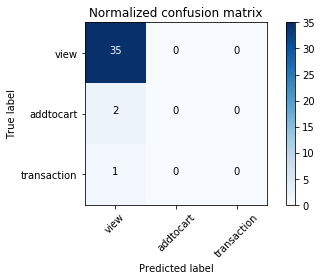

In [0]:
conf=confusion_matrix(y_true,y_pred)
plt.figure()
plot_confusion_matrix(conf, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

## Visualize User Journey Embeddings

In [0]:
embeddings = model.get_layer(name='embedding_4')
embeddings = embeddings.get_weights()[0]
embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))
embeddings = np.nan_to_num(embeddings)

In [0]:
embeddings

array([[-0.02442238, -0.11238019,  0.14504206, ...,  0.11763352,
         0.15338677, -0.14439106],
       [-0.03820889, -0.11839249,  0.15006176, ...,  0.1428828 ,
         0.1328839 , -0.18180448],
       [-0.00971832, -0.13536982,  0.13915087, ...,  0.1668404 ,
         0.14957514, -0.17526533],
       ...,
       [ 0.13134937,  0.07875734,  0.20240417, ...,  0.09817847,
        -0.02122602, -0.11476202],
       [ 0.01542506,  0.1093291 ,  0.0998246 , ..., -0.07506896,
        -0.06041389, -0.04601167],
       [-0.18493702,  0.00885947, -0.14143568, ...,  0.06557115,
        -0.01084917, -0.11345032]], dtype=float32)

In [0]:
from sklearn.manifold import TSNE


In [0]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
embeddings_reduced = tsne.fit_transform(embeddings)

In [0]:
y_labels = np.array(list(map(lambda x: x[50], actions)))

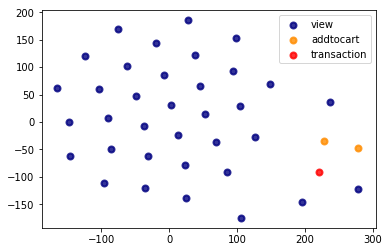

In [67]:
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced[y_labels == i, 0], embeddings_reduced[y_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

In [0]:
from google.colab import drive
drive.mount('/content/drive')